In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import pathlib
import glob

import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
import equinox as eqx

# jax.config.update("jax_platform_name", "cpu")

In [3]:
from mc2.utils.data_inspection import (
    get_available_material_names,
    get_file_overview,
    filter_file_overview,
    load_single_file,
    load_and_process_single_from_full_file_overview,
)
from mc2.utils.data_plotting import plot_single_sequence
from mc2.data_management import FrequencySet, MaterialSet, DataSet

In [4]:
from mc2.training_jax.jax_routine import train_recursive_nn

gpus = jax.devices()
jax.config.update("jax_enable_x64", False)
jax.config.update("jax_default_device", gpus[0])

INFO:2025-07-07 16:25:16,567:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


2025-07-07 16:25:16 | INFO : Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


INFO:2025-07-07 16:25:16,572:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2025-07-07 16:25:16 | INFO : Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [5]:
logs, model = train_recursive_nn(n_epochs=2_000, material="3C90", tbptt_size=512, batch_size=64)

Loading data for 3C90:   0%|          | 0/21 [00:00<?, ?it/s]

Loading data for 3C90: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


2025-07-07 16:25:53 | INFO : max B value in training set: 0.51 T or A/m or °C
2025-07-07 16:25:53 | INFO : max H value in training set: 1313.42 T or A/m or °C
2025-07-07 16:25:54 | INFO : train size: 12075, val size: 2596, test size: 2598


Seed 0:   0%|          | 0/2000 [00:00<?, ?epoch/s]2025-07-07 16:25:57.603448: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-07 16:25:57.603512: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-07 16:25:58.063827: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-07 16:25:58.06

2025-07-07 16:26:05 | INFO : Test loss seed 0: 0.001 A/m


/home/olivers/.conda/envs/venv_mc2/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/home/olivers/.conda/envs/venv_mc2/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:6494: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  delta: Array = lax.convert_element_type(stop - start, computation_dtype) / array(div, dtype=computation_dtype)
/home/olivers/.con

2025-07-07 16:39:05 | INFO : Test loss seed 0: 0.000 A/m


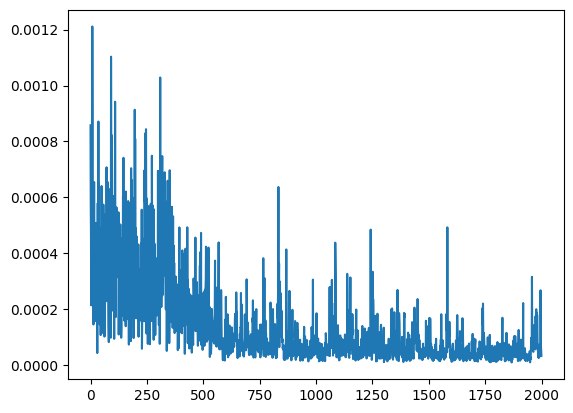

In [6]:
plt.plot(logs["loss_trends_train"])

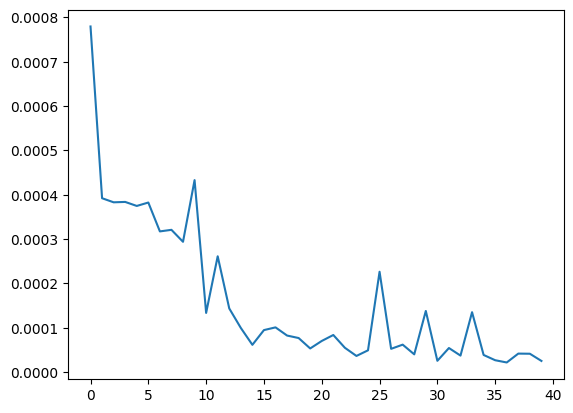

In [7]:
plt.plot(logs["loss_trends_val"])

In [8]:
from mc2.data_management import load_data_into_pandas_df, MaterialSet
from mc2.training_jax.jax_routine import normalize_material_set

data_dict = load_data_into_pandas_df(material="3C90")
mat_set = MaterialSet.from_pandas_dict(data_dict)

train_set, val_set, test_set = mat_set.split_into_train_val_test(train_frac=0.7, val_frac=0.15, test_frac=0.15, seed=12)
max_l_d = {"B": [], "H": []}
max_d = {"B": None, "H": None, "T": 100}  # max temperature is 100°C

for freq_set in train_set.frequency_sets:
    max_B = jnp.abs(freq_set.B).max()
    max_H = jnp.abs(freq_set.H).max()
    max_l_d["B"].append(float(max_B))
    max_l_d["H"].append(float(max_H))

for k, max_l in max_l_d.items():
    max_v = max(max_l)
    max_d[k] = max_v

# convert to torch tensor, normalize
train_set_norm = normalize_material_set(train_set, max_d, reduce_train=False)
val_set_norm = normalize_material_set(val_set, max_d)
test_set_norm = normalize_material_set(test_set, max_d)

Loading data for 3C90:   0%|          | 0/21 [00:00<?, ?it/s]

Loading data for 3C90: 100%|██████████| 21/21 [00:12<00:00,  1.69it/s]


In [9]:
FREQ_CATEGORIES = jnp.array([50000.0, 80000.0, 125000.0, 200000.0, 320000.0, 500000.0, 800000.0])


# def one_hot_frequency_vectorized(f_batch):
#     # f_batch shape: (batch, seq_len)
#     # Map frequencies to indices
#     indices = jnp.argmin(jnp.abs(f_batch[..., None] - FREQ_CATEGORIES), axis=-1)
#     return jax.nn.one_hot(indices, num_classes=len(FREQ_CATEGORIES))
from mc2.features.features_jax import add_fe
from mc2.training_jax.jax_routine import H_FACTOR

def featurize(B, H, T, f):
    # f = jnp.squeeze(f, axis=-1)
    # one_hot_f = one_hot_frequency_vectorized(f)
    fes = add_fe(jnp.reshape(B, (1, -1)), n_s=B.shape[0])
    return jnp.concatenate([B, fes[0], T, f], axis=-1), jnp.tanh(H_FACTOR * H)

Frequence: 50000.0


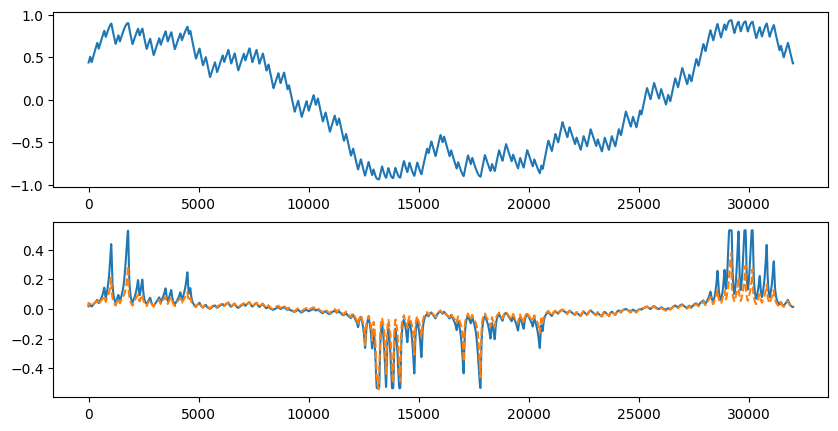

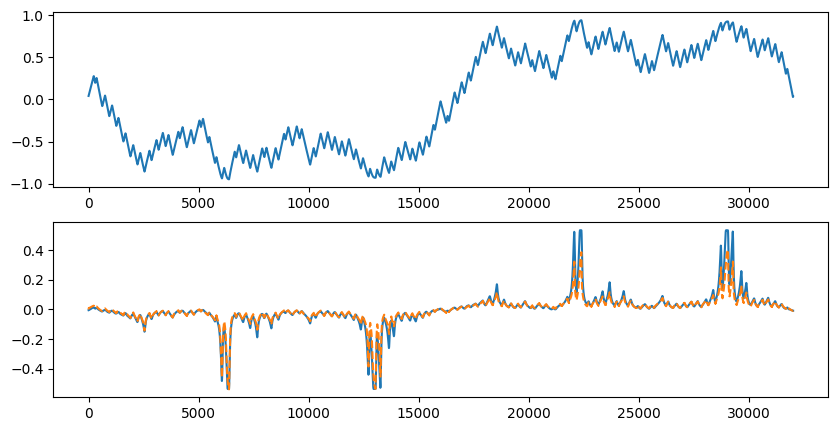

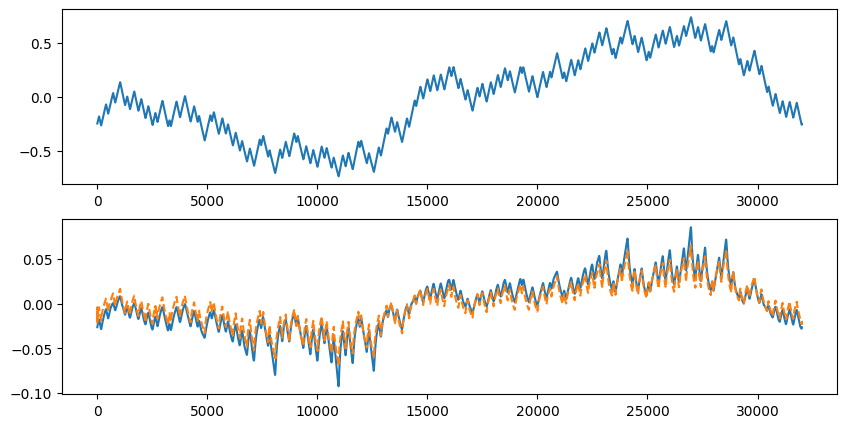

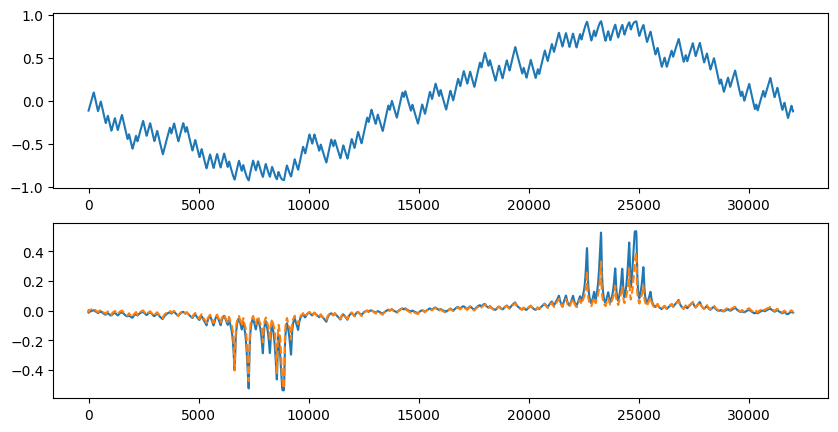

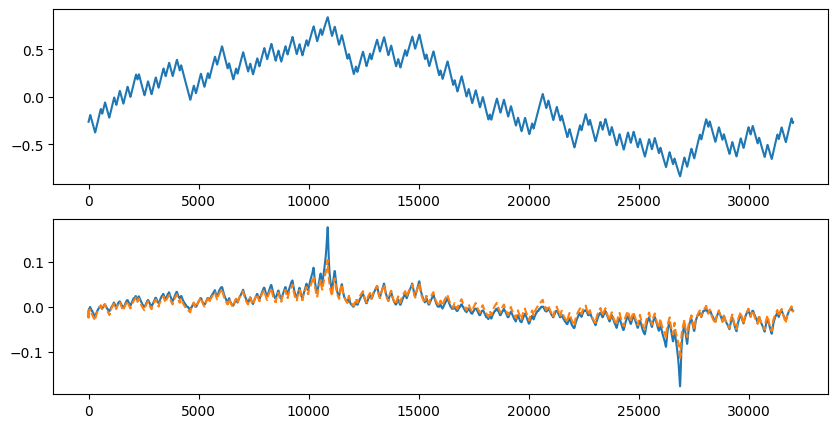

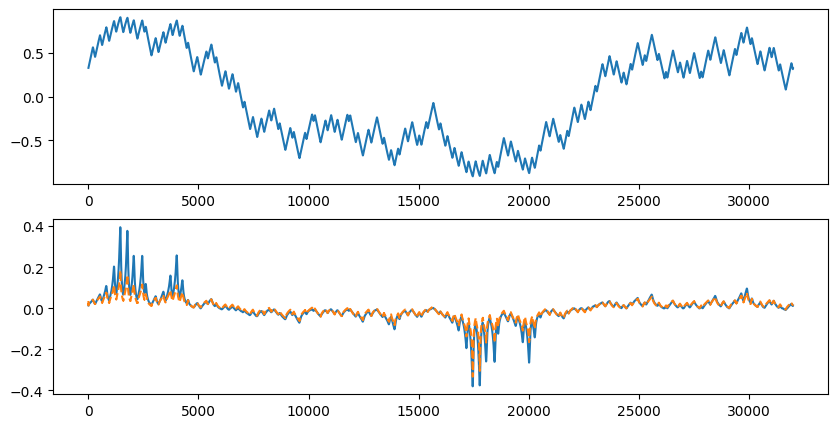

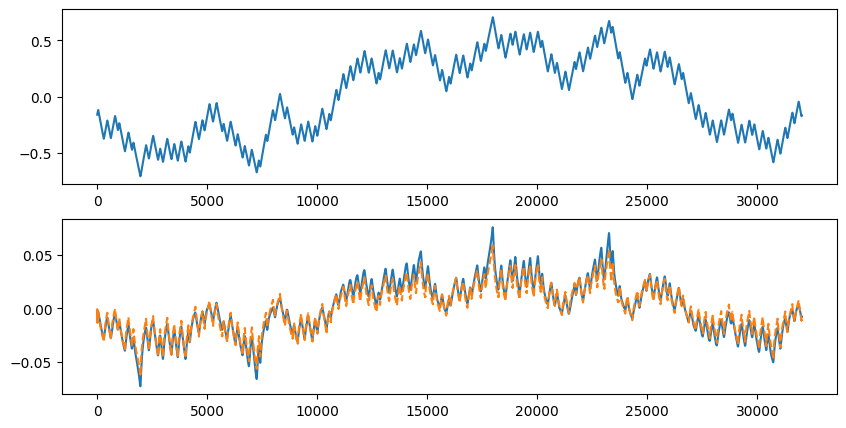

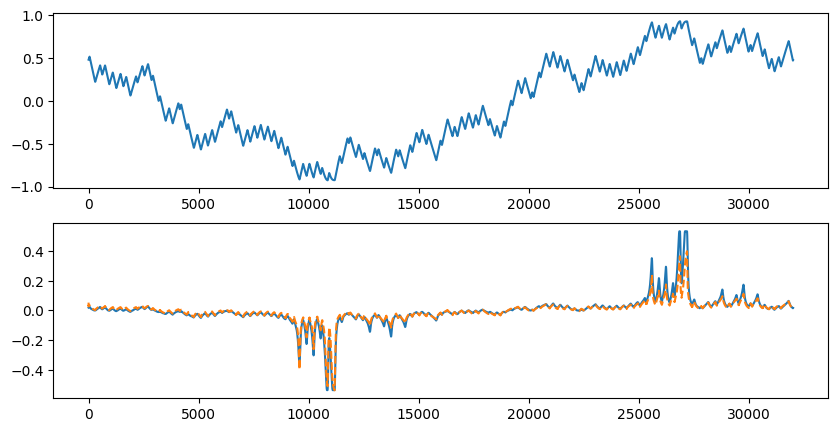

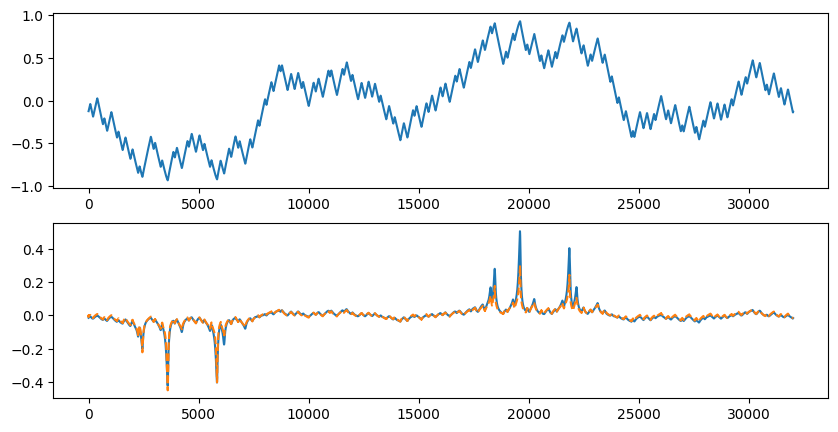

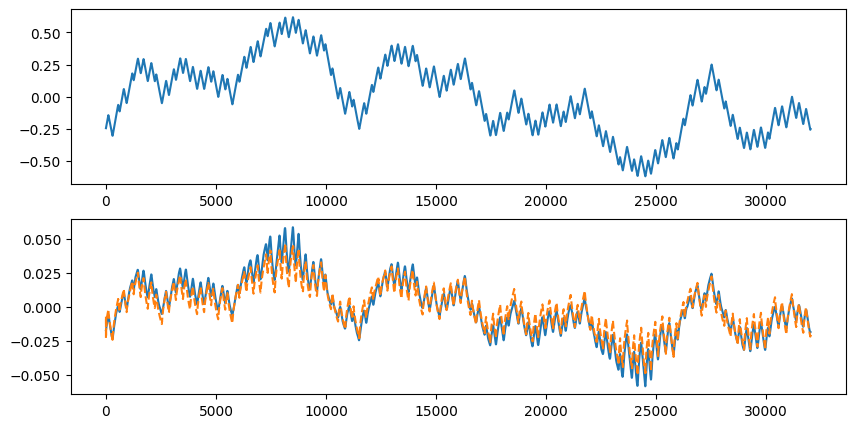

Frequence: 80000.0


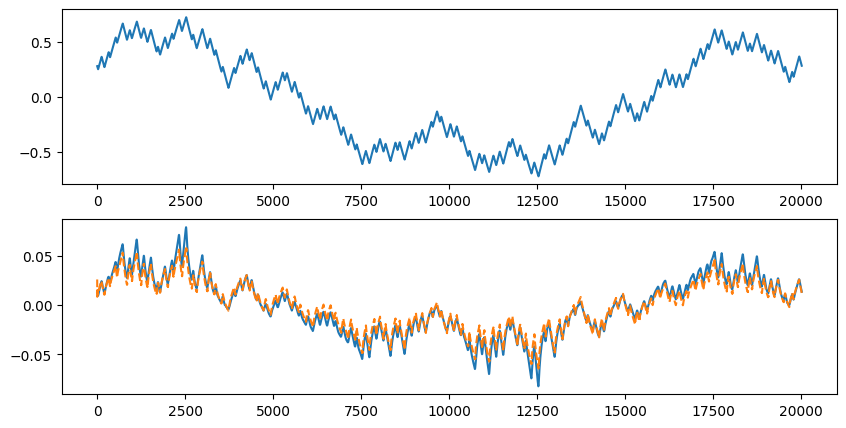

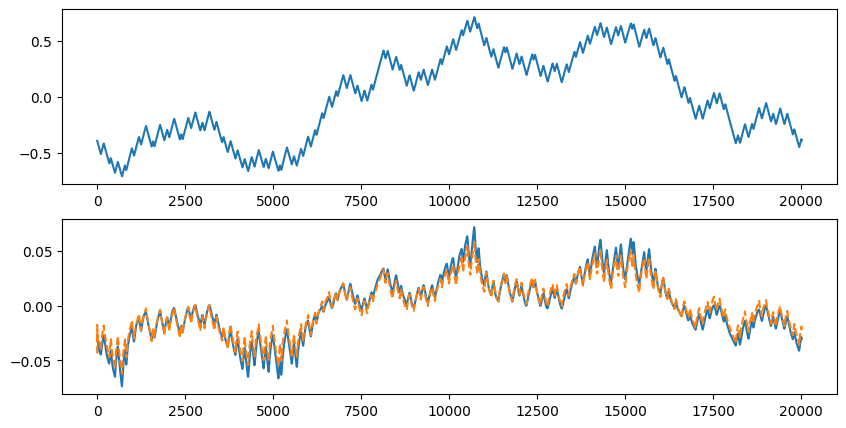

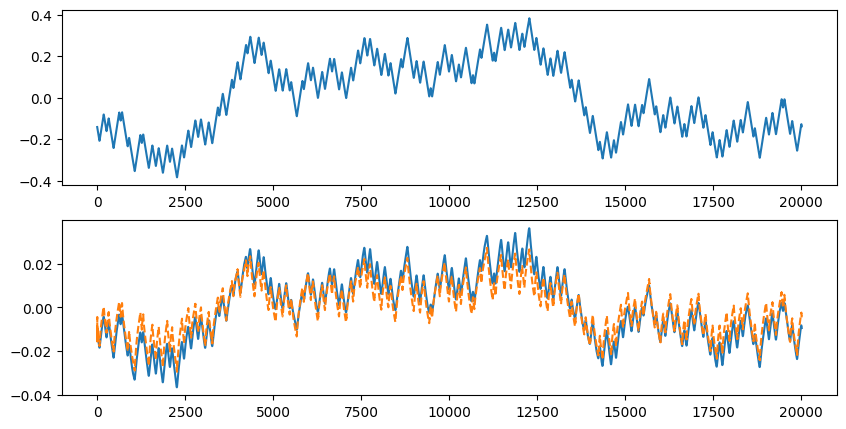

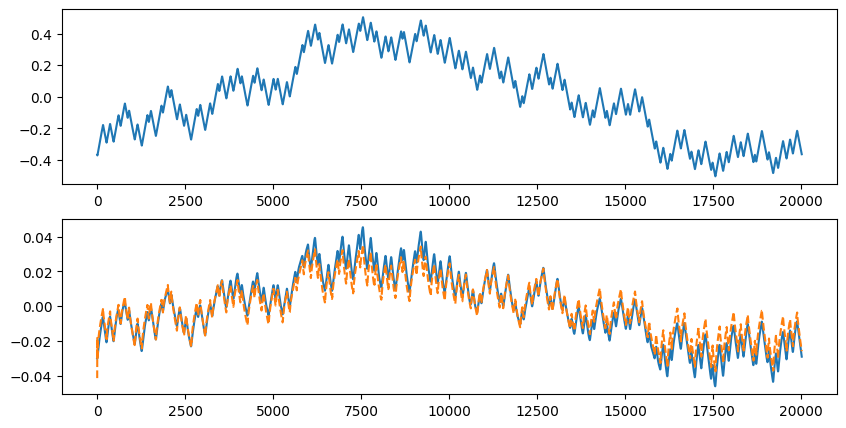

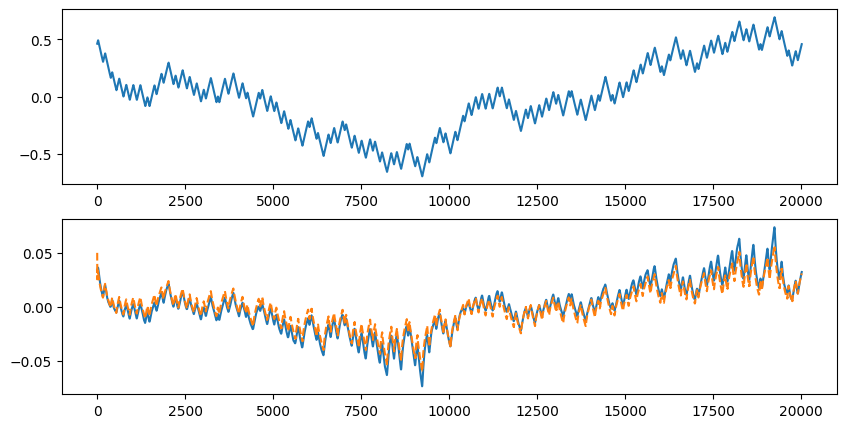

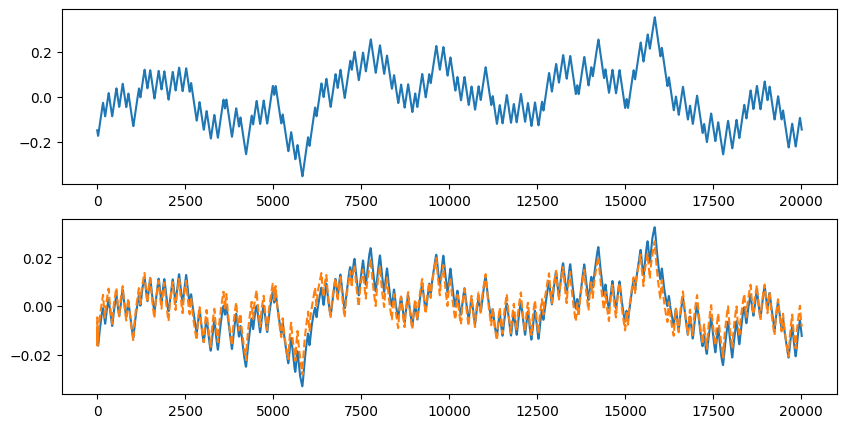

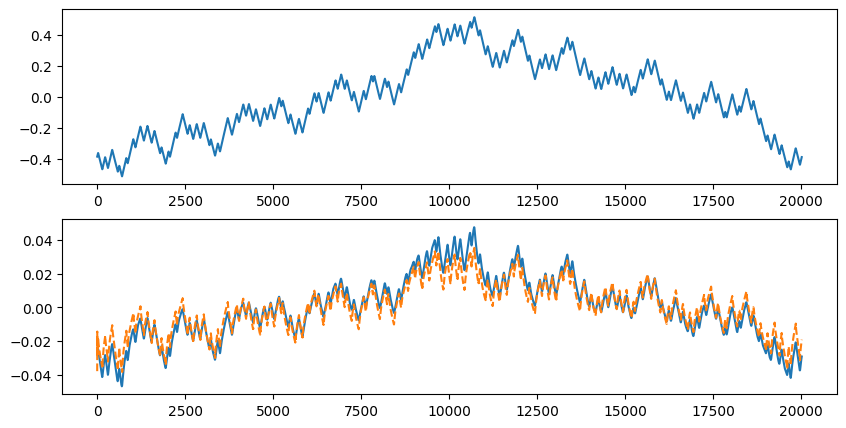

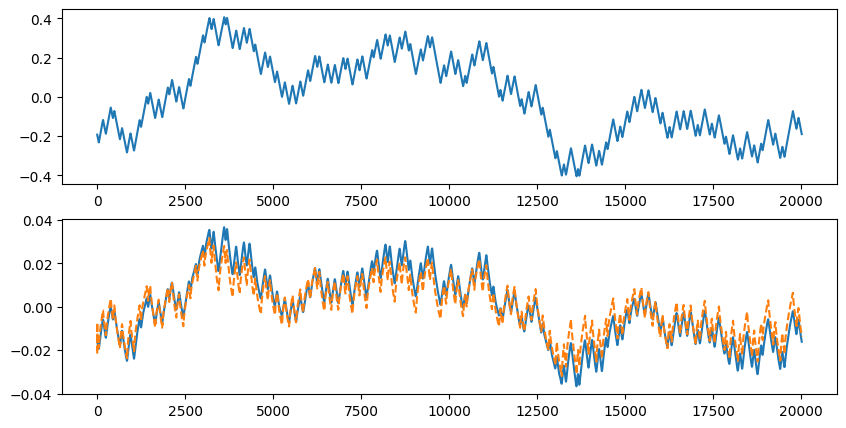

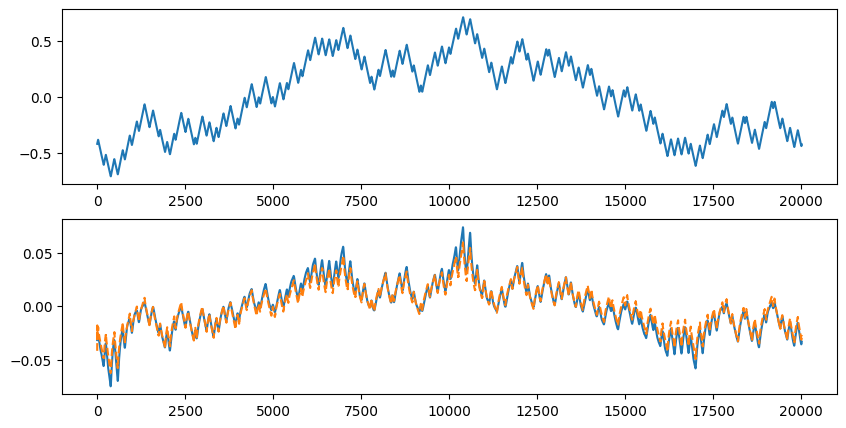

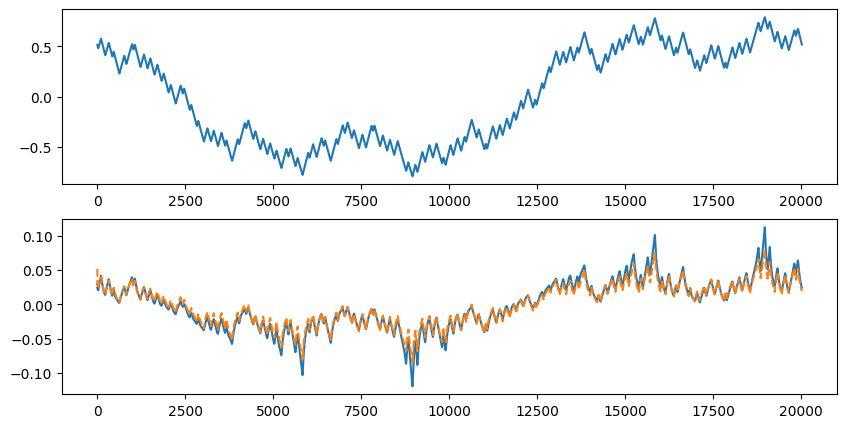

Frequence: 125000.0


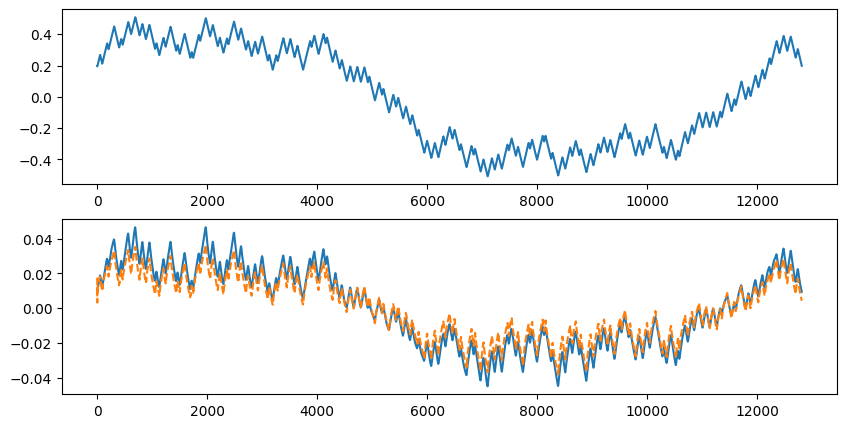

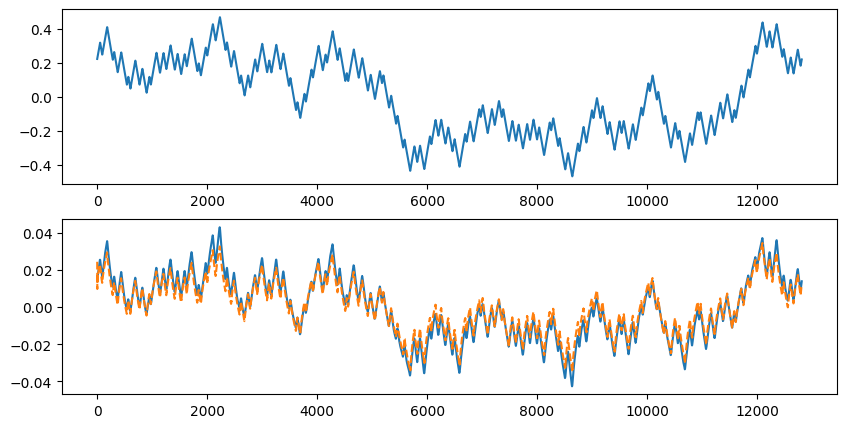

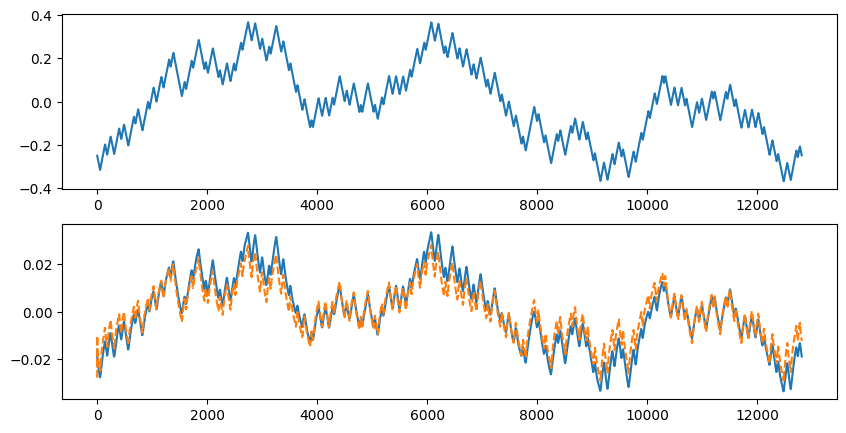

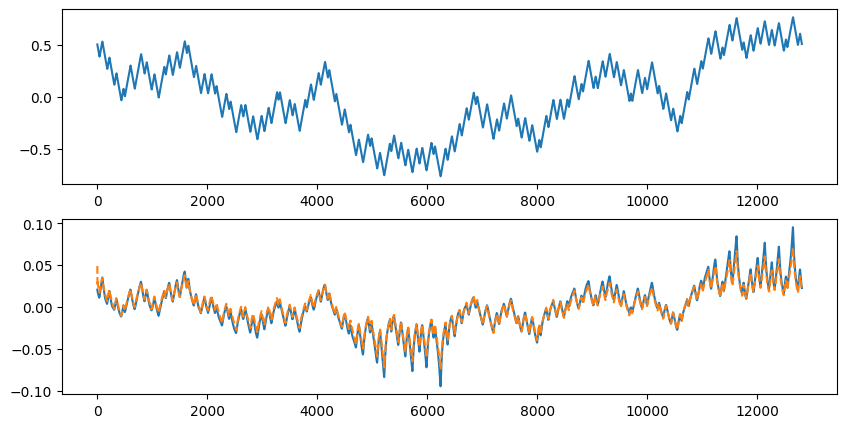

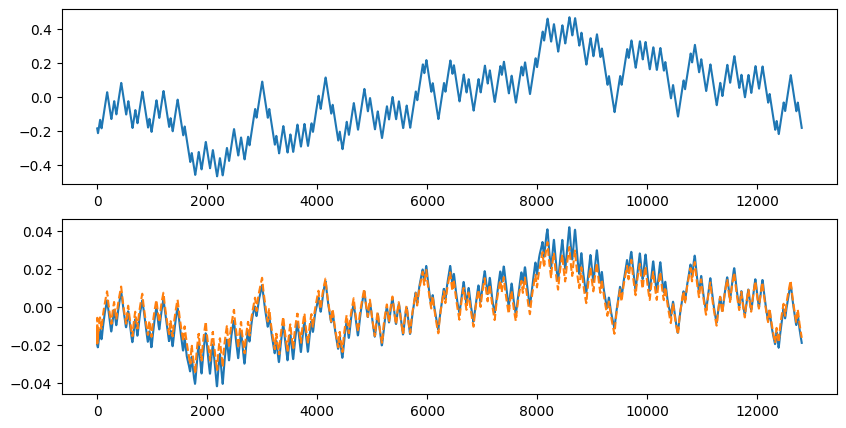

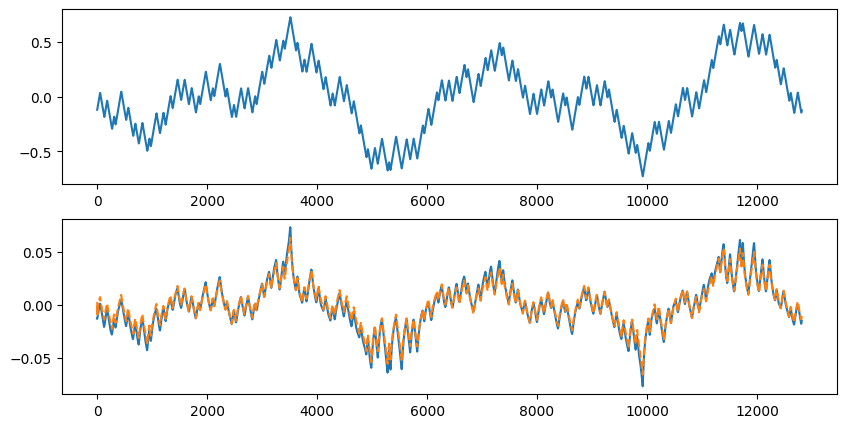

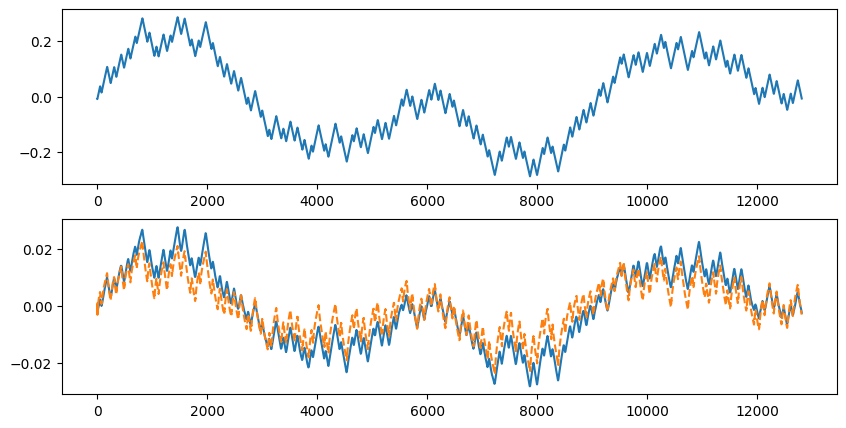

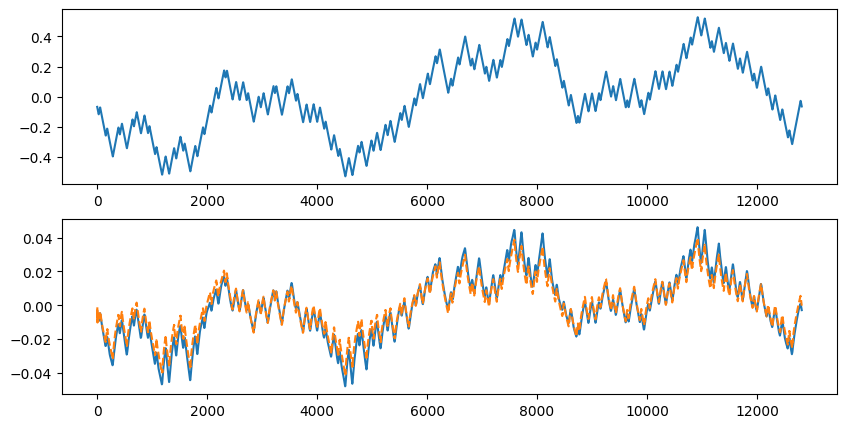

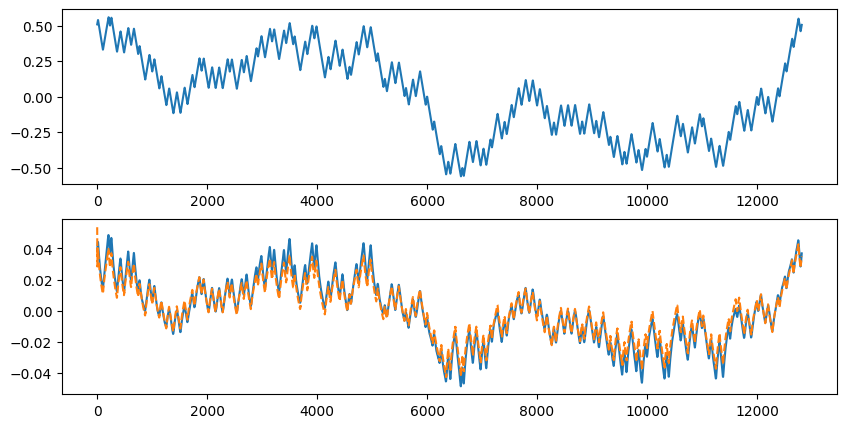

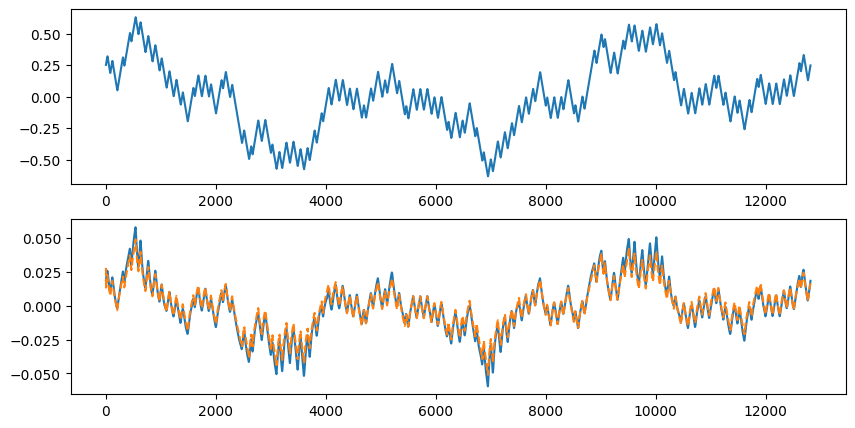

Frequence: 200000.0


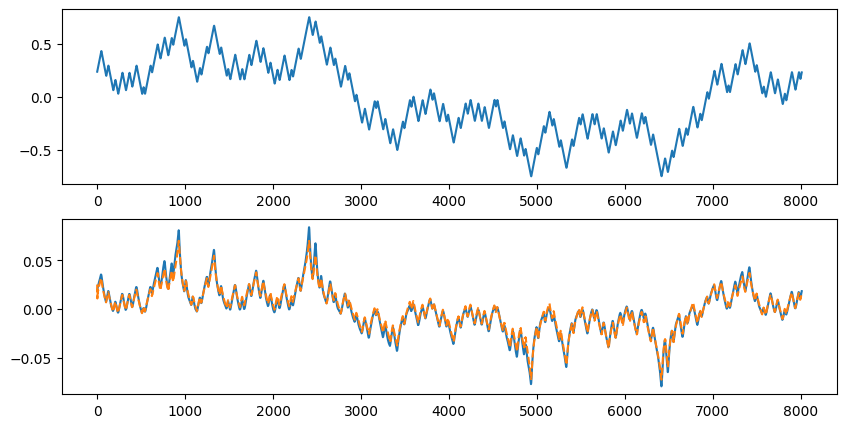

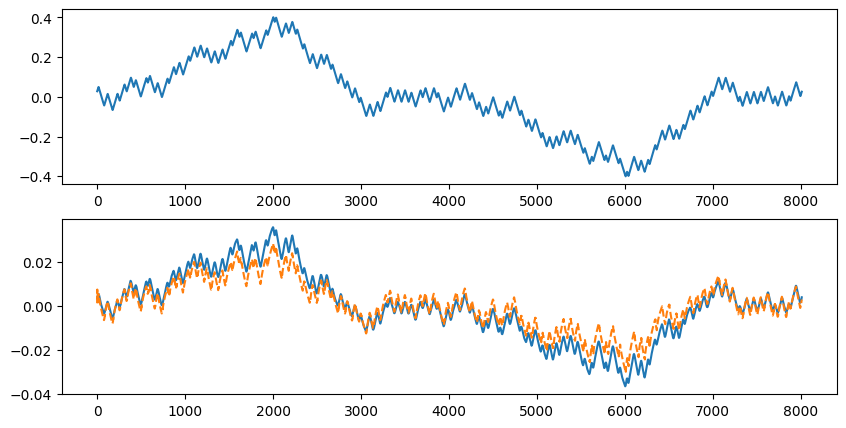

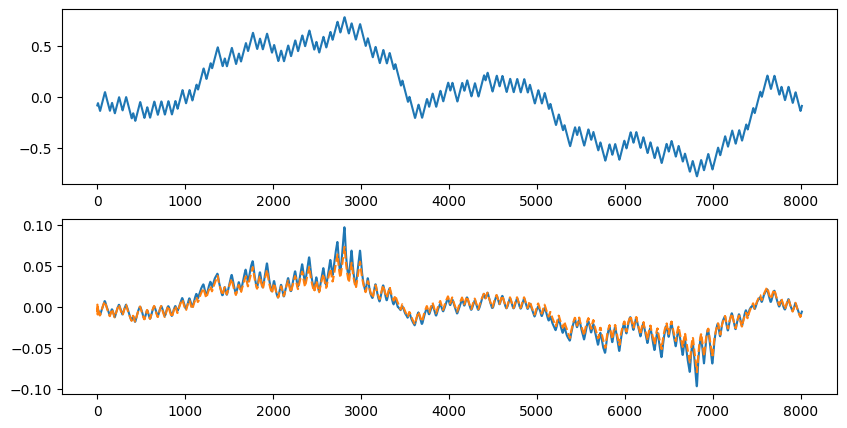

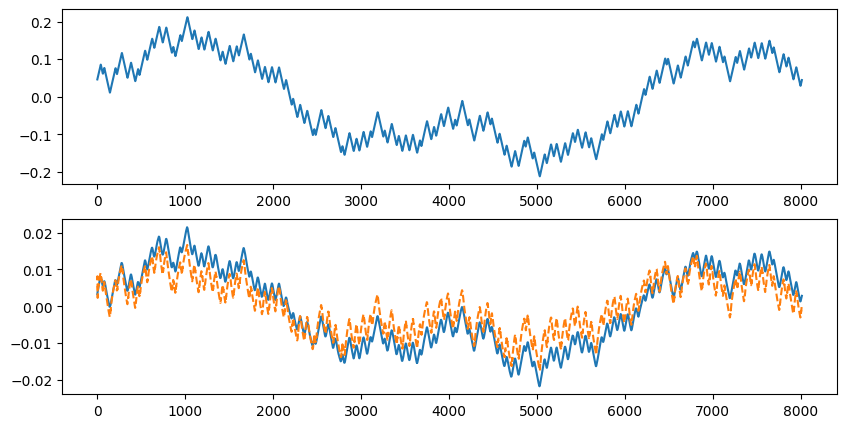

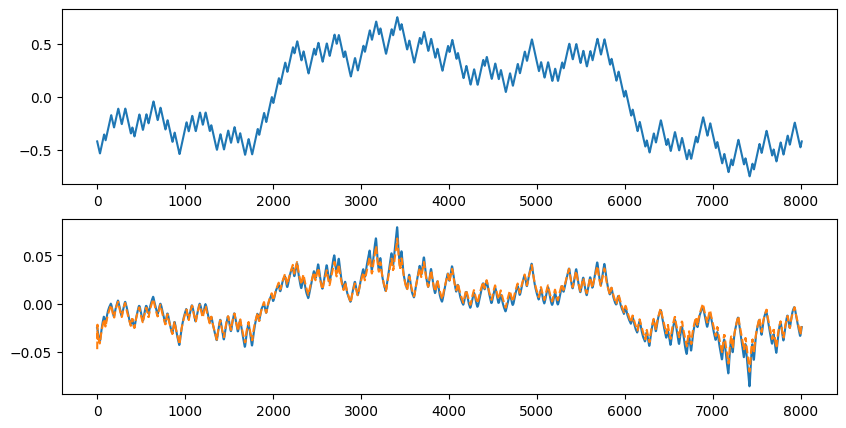

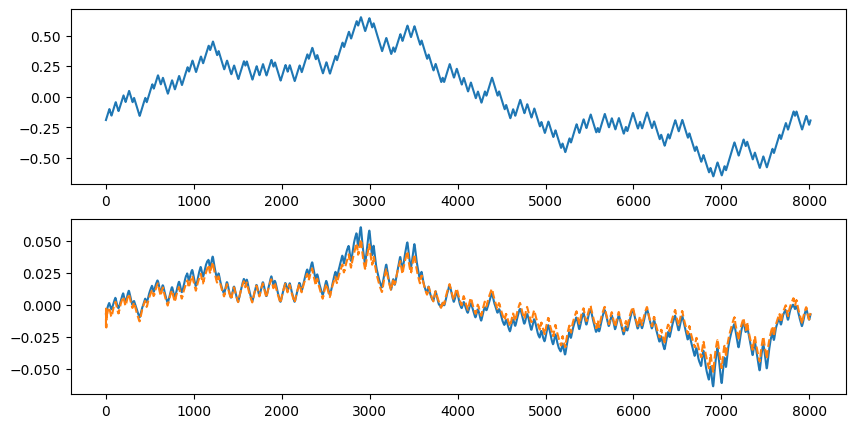

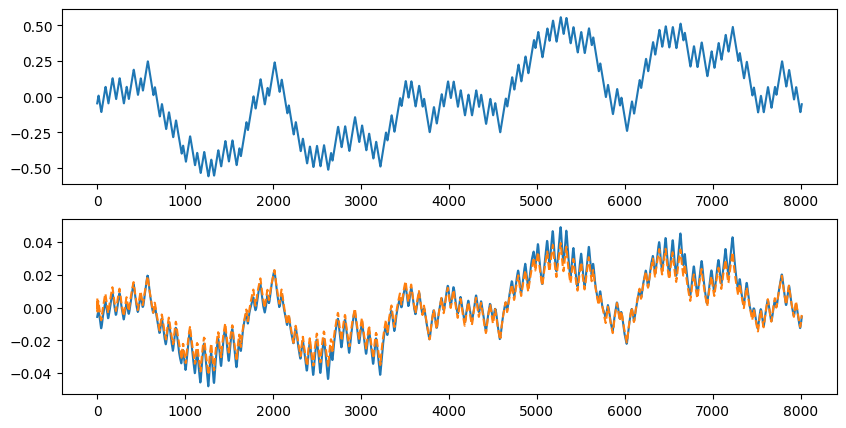

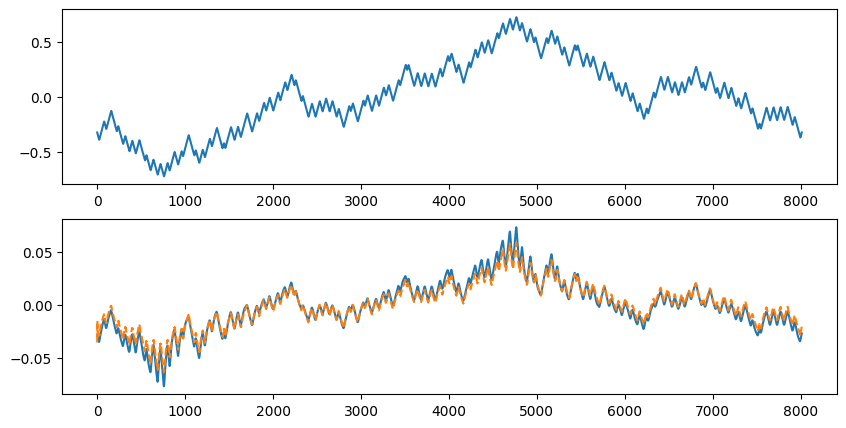

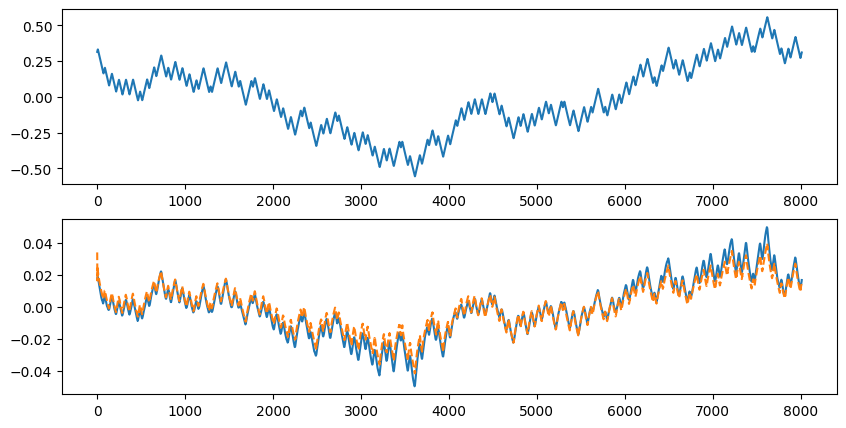

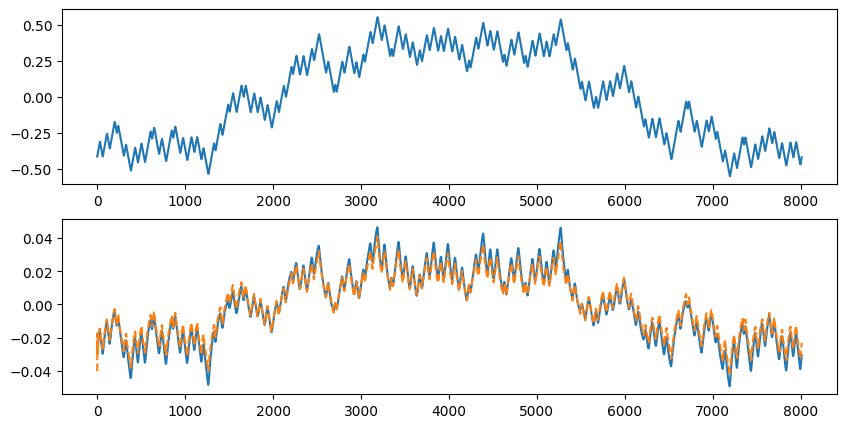

Frequence: 320000.0


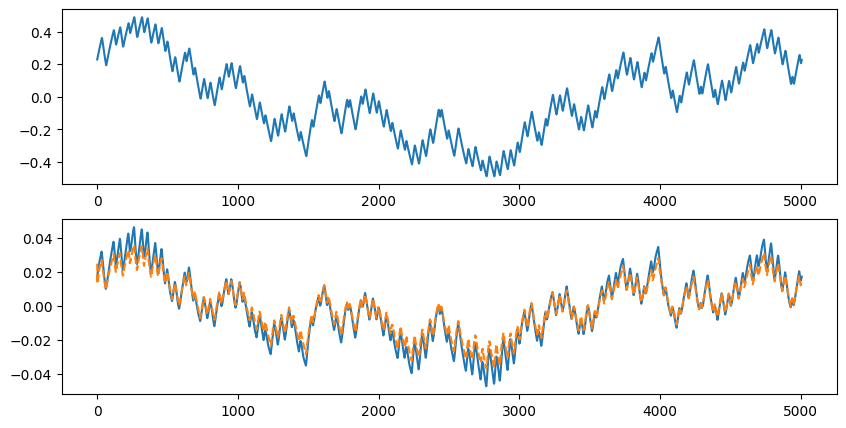

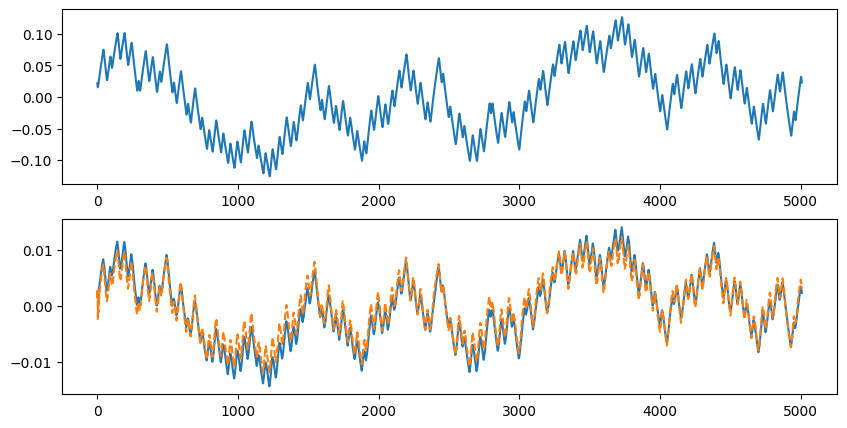

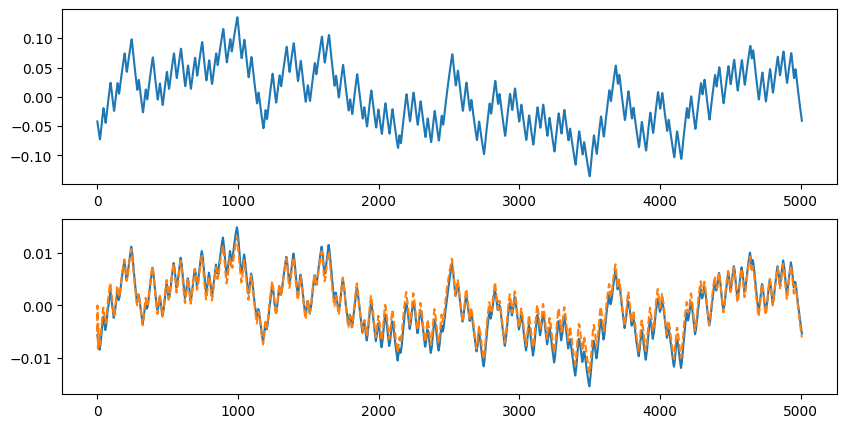

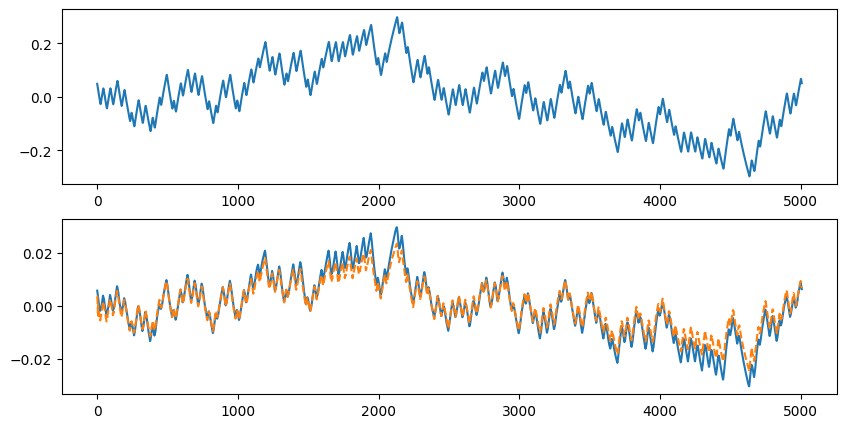

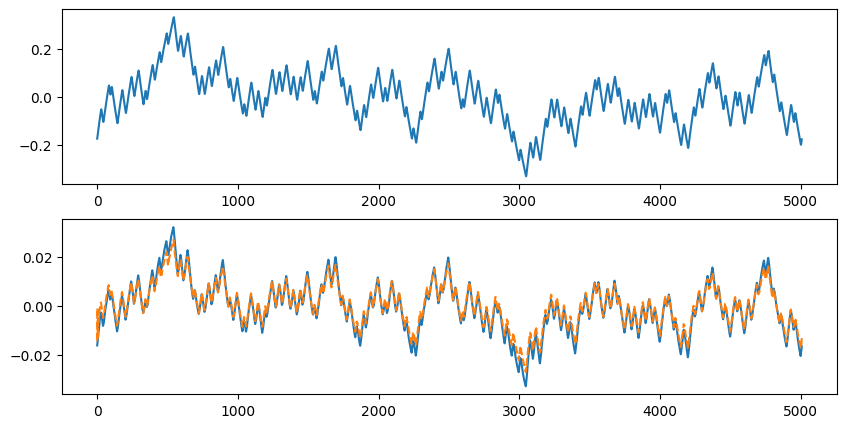

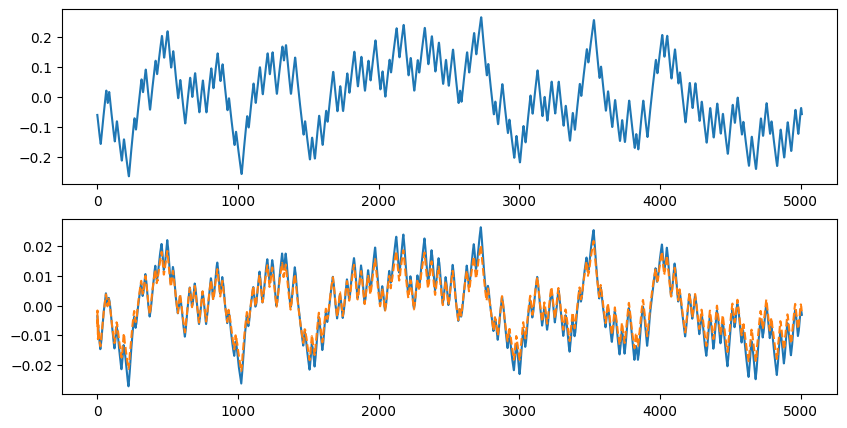

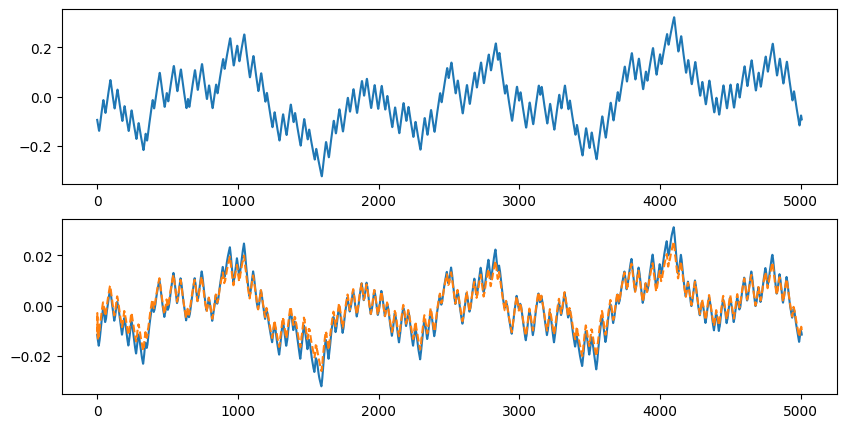

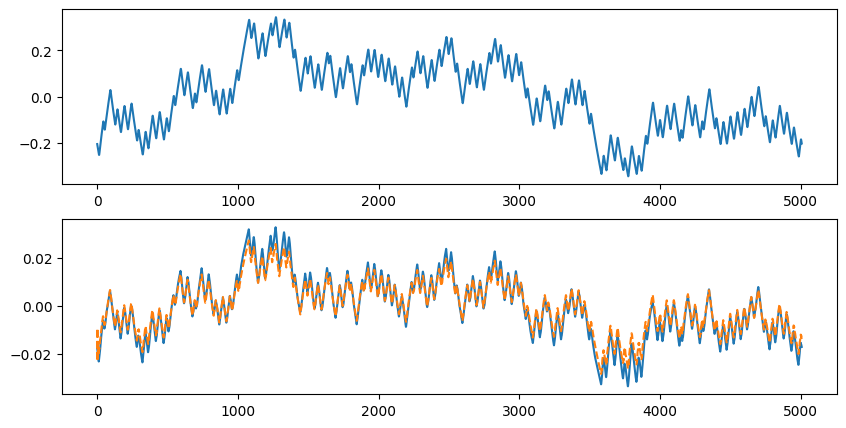

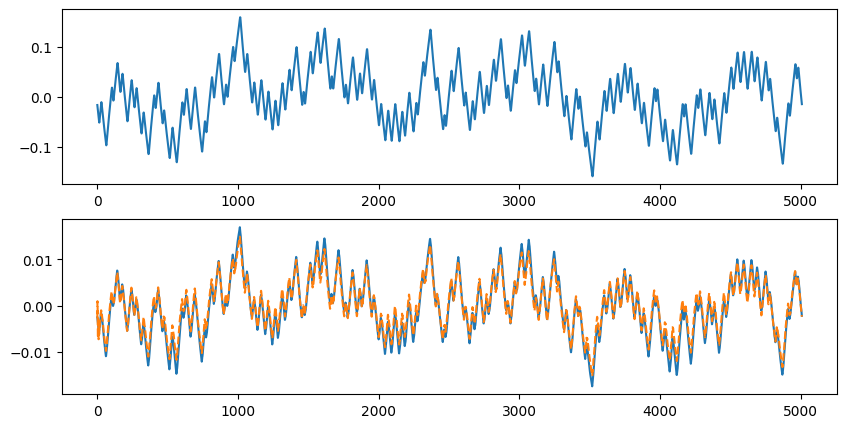

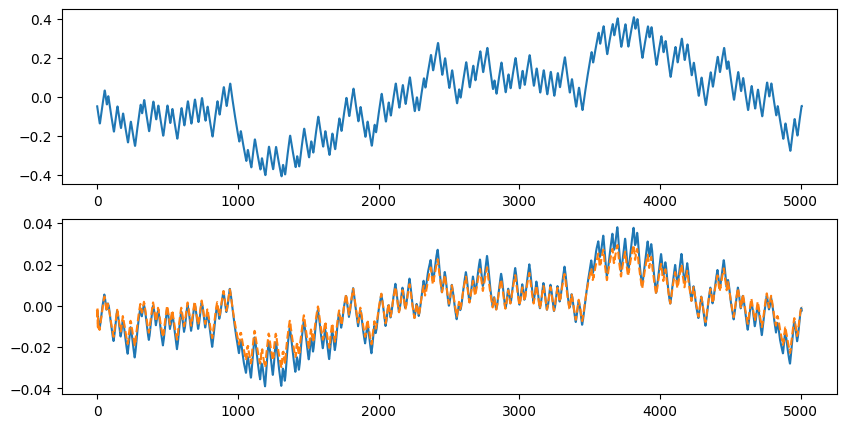

Frequence: 500000.0


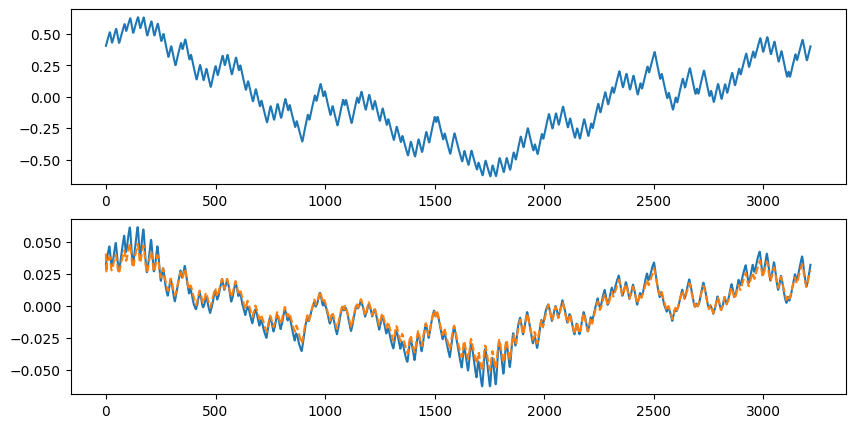

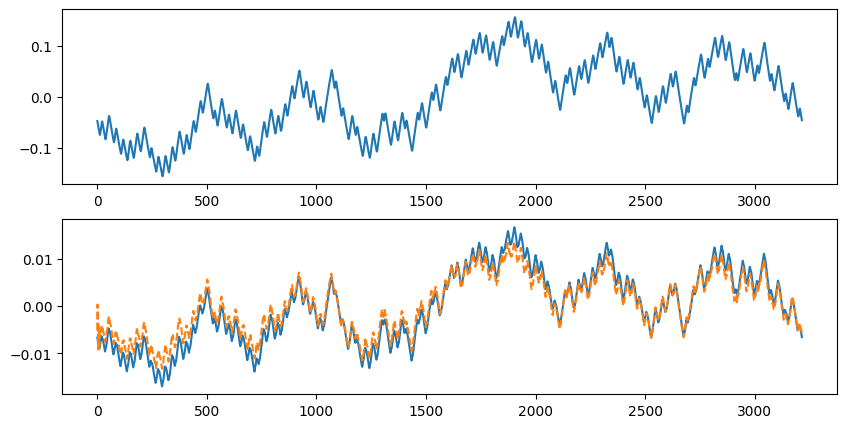

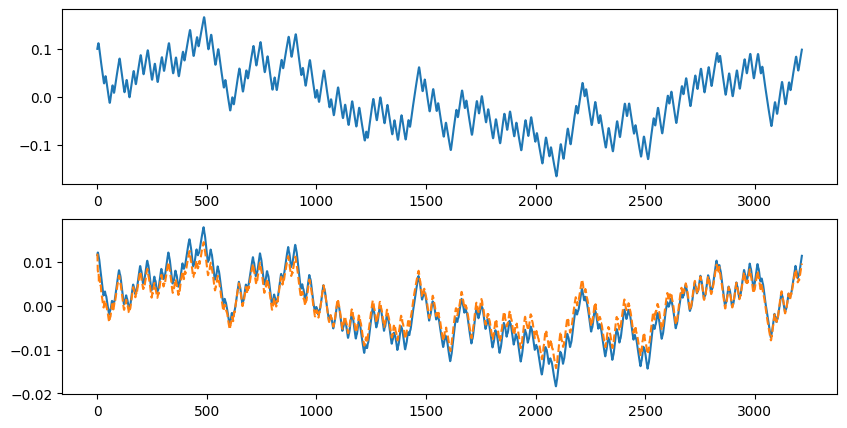

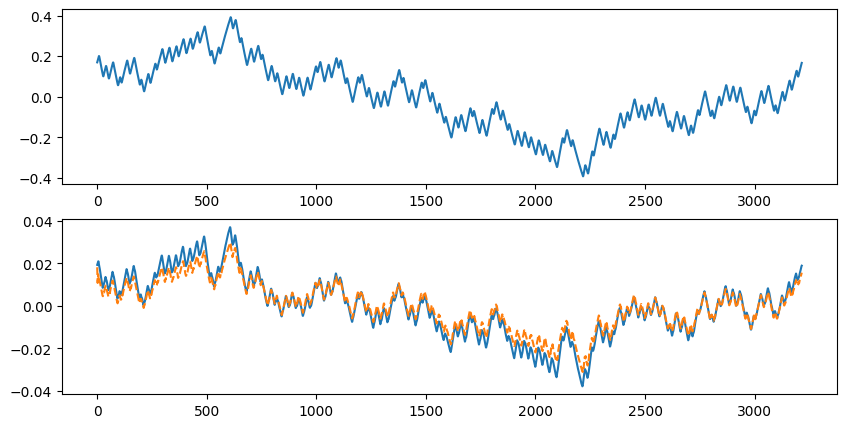

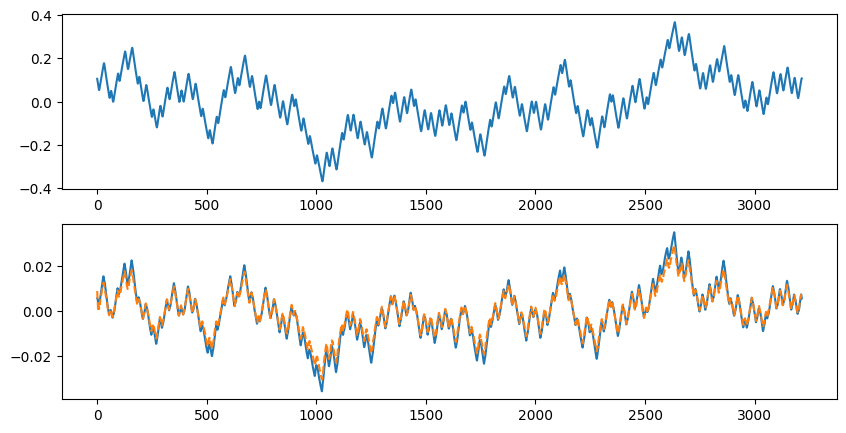

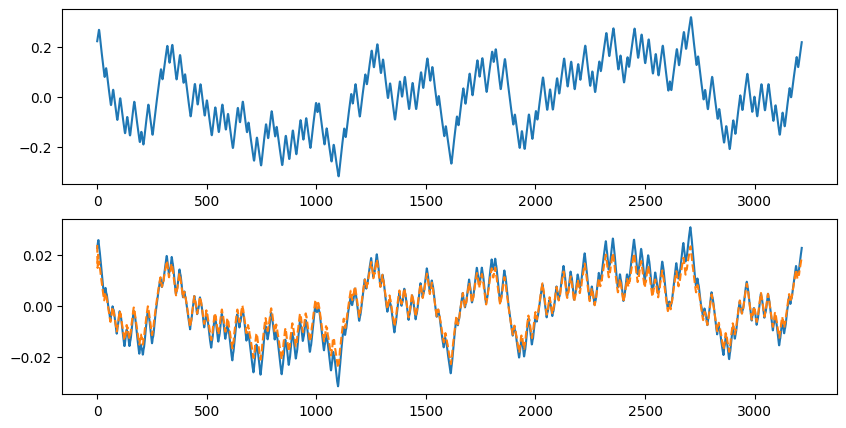

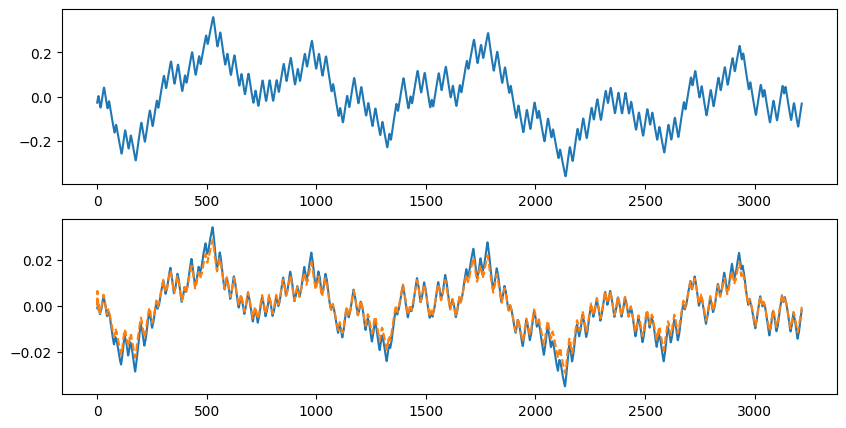

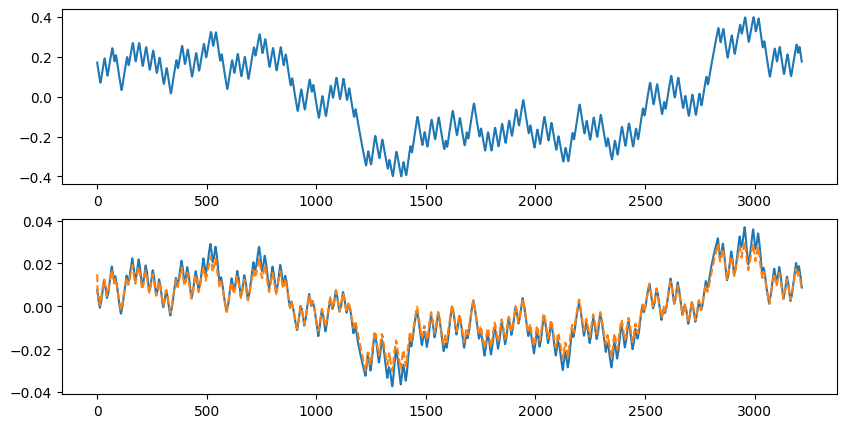

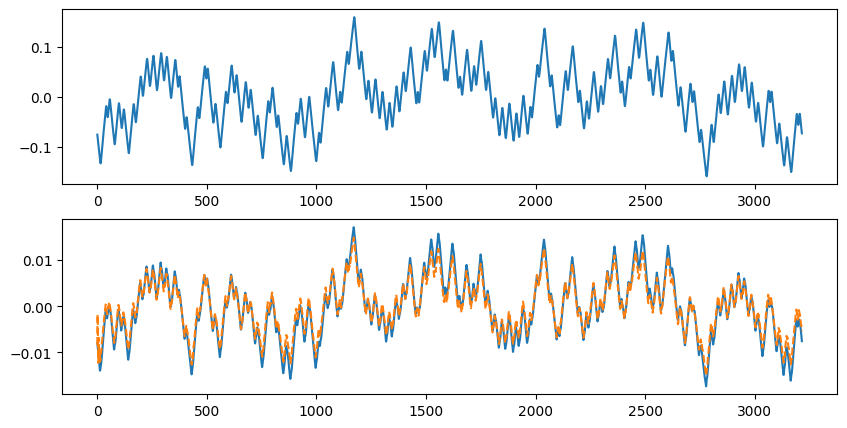

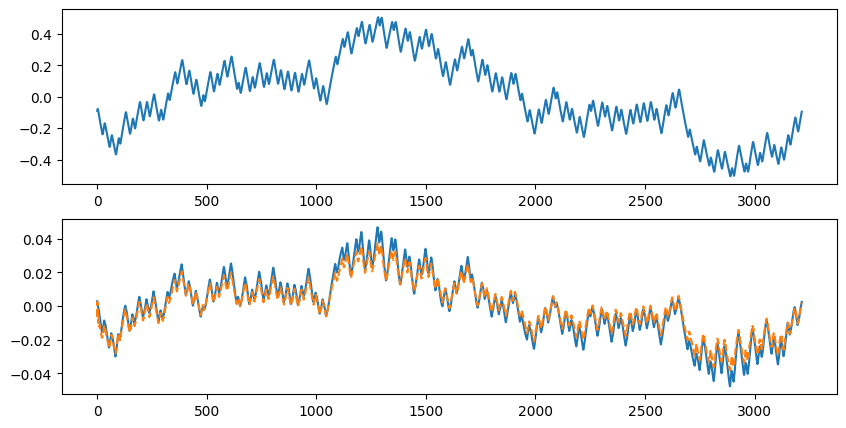

Frequence: 800000.0


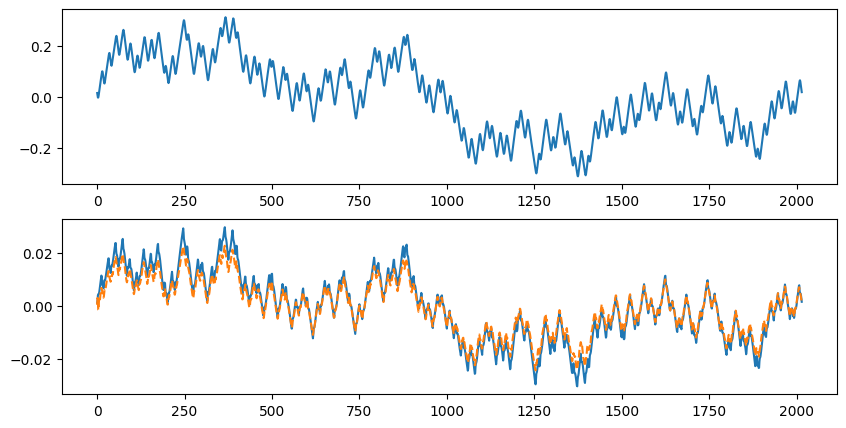

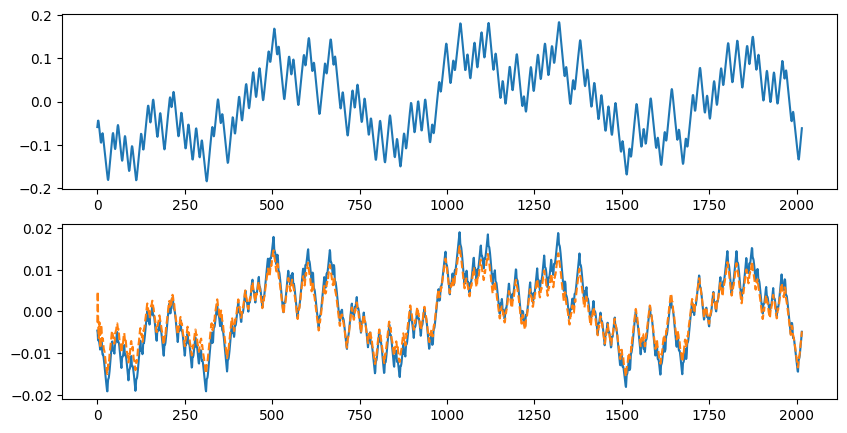

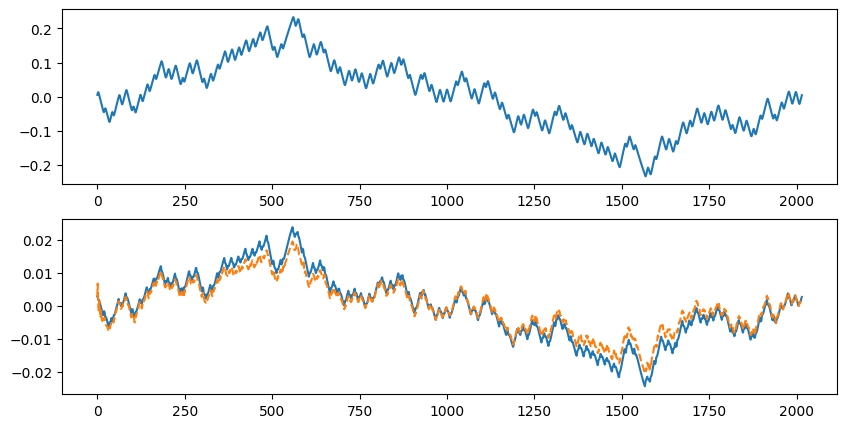

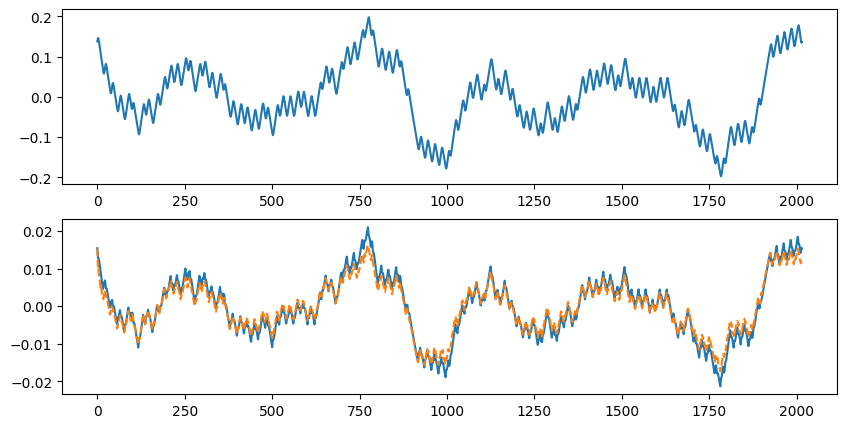

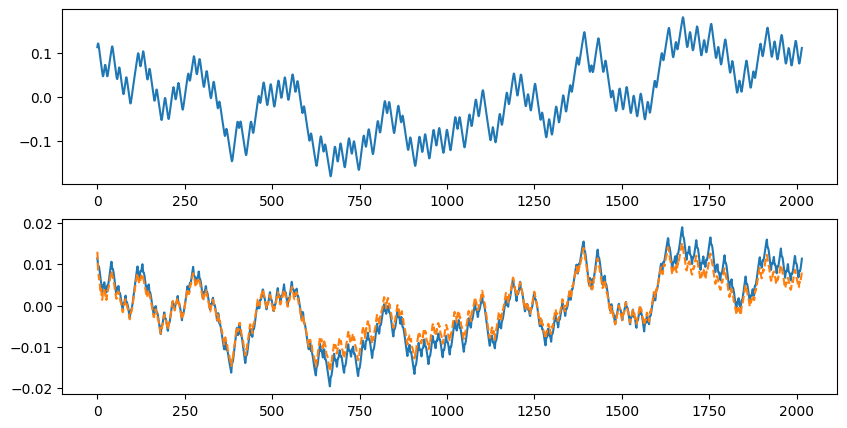

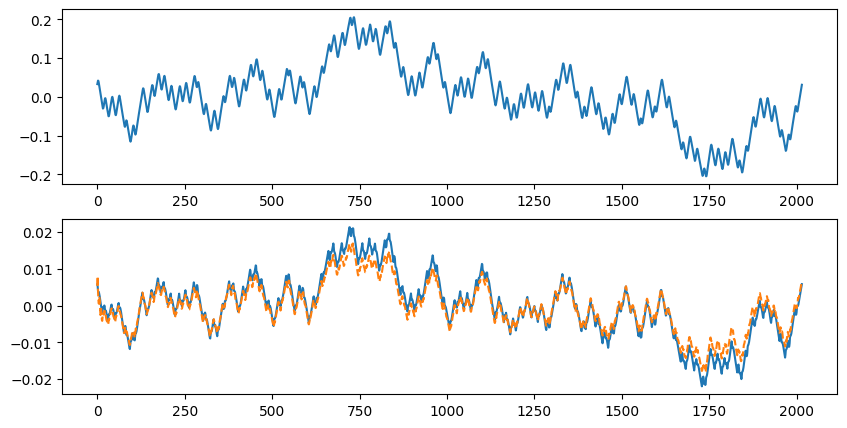

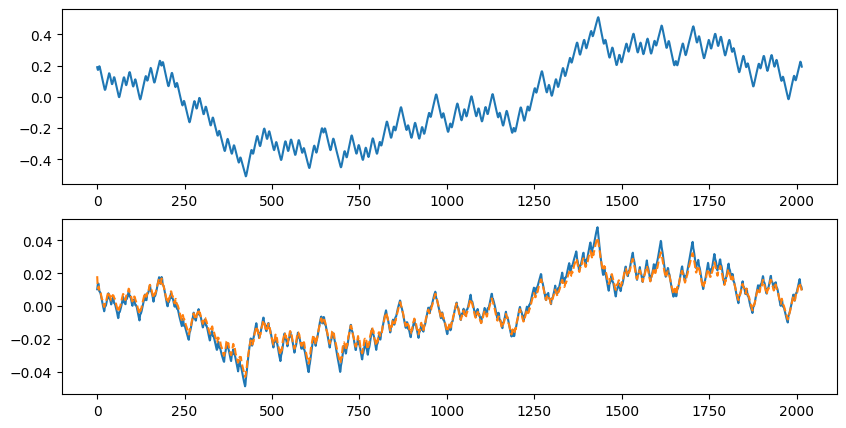

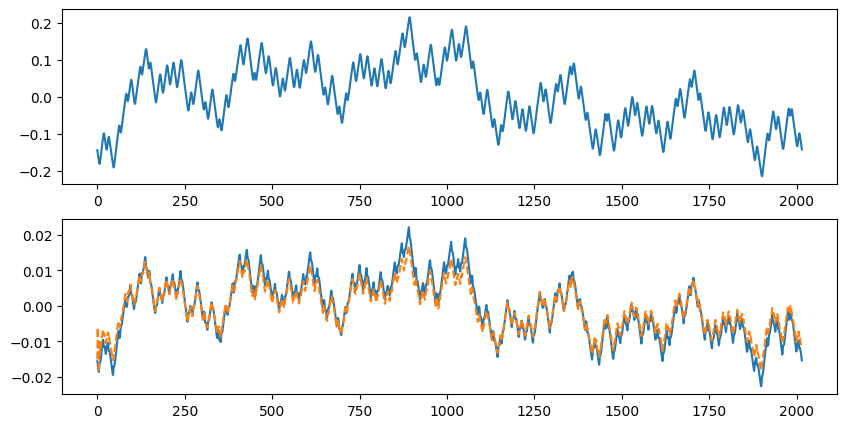

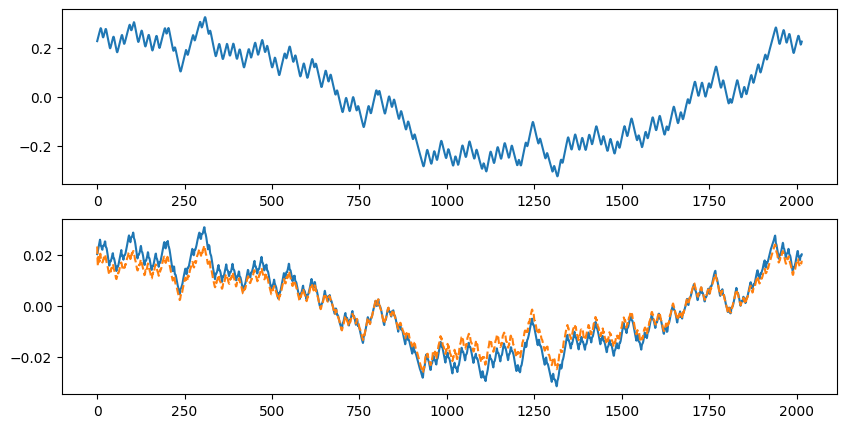

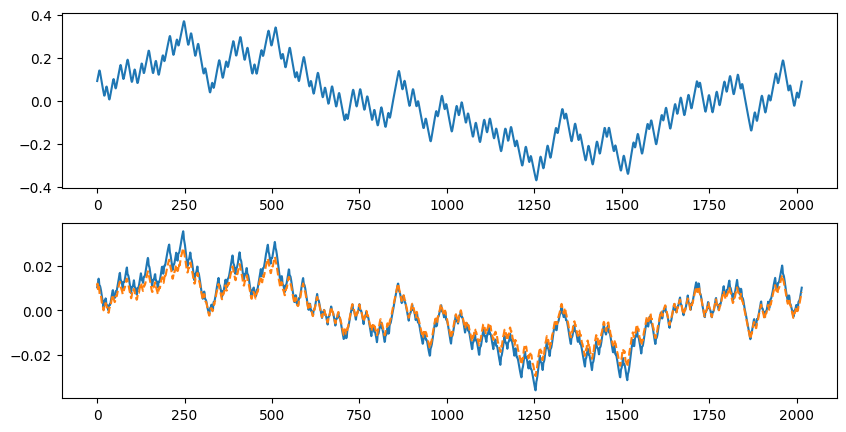

In [14]:
from mc2.training.data_sampling import draw_data_uniformly

def inverse_tanh_scaled(y, H_FACTOR, eps=1e-6):
    # Clipping to avoid values at or beyond ±1
    y_clipped = jnp.clip(y, -1 + eps, 1 - eps)
    return jnp.arctanh(y_clipped) / H_FACTOR

key = jax.random.PRNGKey(10)
key, subkey = jax.random.split(key)
for j in range(7):
    print("Frequence:",FREQ_CATEGORIES[j])
    for i in range(10):

        B = test_set_norm[j].B[i][:]
        H = test_set_norm[j].H[i][:]
        T = test_set_norm[j].T[i]
        f = test_set_norm.frequencies[j]

        

        B_t = B[..., None]
        H_t = H[..., None]
        T_t = jnp.broadcast_to(jnp.array([T])[:, None], B_t.shape)
        f_t = f * jnp.ones_like(B_t) / 800_000

        # print(B_t.shape, H_t.shape, T_t.shape, f_t.shape, "Featurize shapes")
        x, y = featurize(B_t, H_t, T_t, f_t)
        pred_y = model(x)
    
        fig, ax = plt.subplots(2, 1, figsize=(10, 5))
        ax[0].plot(x[:, 0])
        ax[1].plot(y[:])
        ax[1].plot(pred_y[:],linestyle='--')
        plt.show()


In [11]:
from mc2.training.data_sampling import draw_data_uniformly

key = jax.random.PRNGKey(12354)
key, subkey = jax.random.split(key)
freq_set = train_set_norm[0]
batch_B, batch_H, batch_T, _ = draw_data_uniformly(
    freq_set, training_sequence_length=1024, training_batch_size=2, loader_key=subkey
)

batch_f = freq_set.frequency * jnp.ones_like(batch_B)
print("B.shape:", (batch_B[0]).shape)
print("H.shape:", (batch_H[0]).shape)
print("T.shape:", (batch_T[0]).shape)
print("f.shape:", (batch_f[0]).shape)
x_2, y_2 = featurize(batch_B[0], batch_H[0], batch_T[0], batch_f[0])
pred_y = model(x_2)

B.shape: (1024, 1)
H.shape: (1024, 1)
T.shape: (1024, 1)
f.shape: (1024, 1)


In [12]:
x_2.shape

(1024, 8)

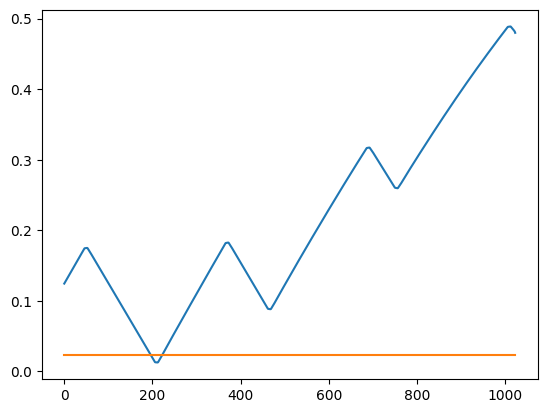

In [13]:
plt.plot(y_2)
plt.plot(pred_y)